# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [66]:
# Import libraries
# Standard library
import os
import warnings

# Core Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-Learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [11]:
# Define a function to load data and aggregate them
def load_and_merge_stock_data(file_list):
    dataframes = []

    for file in file_list:
        # Extract stock name from filename
        stock_name = os.path.basename(file).split('_')[0]

        # Read the CSV file
        df = pd.read_csv(file)
        
        # Convert 'Date' to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Drop the 'Name' column
        df.drop(columns=['Name'], inplace=True)

        # Rename columns with stock prefix (except Date)
        df.rename(columns={col: f"{stock_name}_{col}" for col in df.columns if col != 'Date'}, inplace=True)

        dataframes.append(df)

    # Merge all DataFrames on 'Date'
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on='Date')

    return merged_df

In [12]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_list = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
merged_df  = load_and_merge_stock_data(file_list)

In [13]:
# View specifics of the data
print(merged_df .head())

        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58      7582127   
1 2006-01-04      47.48      47.73     46.69       47.25      7440914   
2 2006-01-05      47.16      48.20     47.11       47.65      5417258   
3 2006-01-06      47.97      48.58     47.32       47.87      6154285   
4 2006-01-09      46.55      47.10     46.40       47.08      8945056   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Close  \
0    80.81 

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [15]:
# Handle Missing Values
# Identify Missing Values
print(merged_df.isnull().sum())

Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


In [16]:
# Handle Missing Values by forward fill
merged_df.ffill(inplace=True)


In [17]:
# verify
print(merged_df.isnull().sum())

Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


- All the missing values Handled properly

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

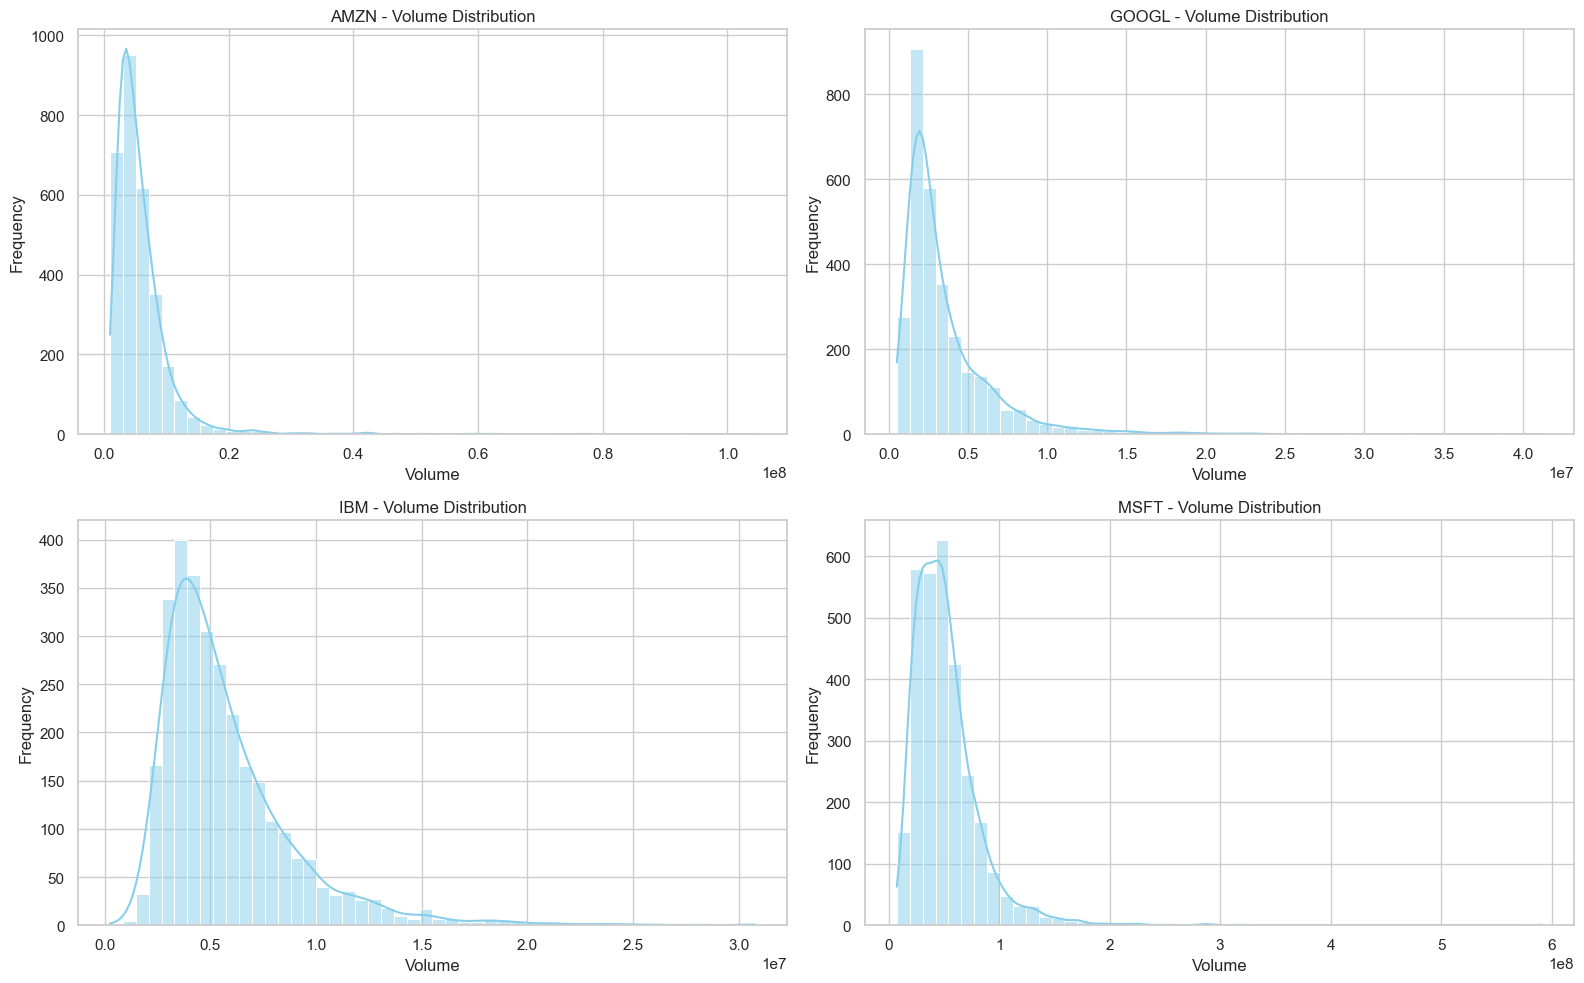

In [20]:
# Frequency distribution of volumes
# Set a style
# Import libraries
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

companies = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Plot histograms for each company's trading volume
for i, company in enumerate(companies):
    plt.subplot(2, 2, i+1)
    sns.histplot(merged_df[f'{company}_Volume'], bins=50, kde=True, color='skyblue')
    plt.title(f'{company} - Volume Distribution')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Volume Distribution Observations**

- Looking at the frequency distribution plots for the trading volumes of Amazon, Google, IBM, and Microsoft, a clear pattern emerges across all four stocks.

- Each plot shows the frequency of different trading volume levels. It's evident that the distributions are heavily skewed towards the lower end of the volume spectrum. This means that for all these companies, the most frequent trading activity occurs at relatively lower volumes.

- We can see a sharp peak in the frequency at these lower volume ranges for each stock. As the volume increases, the frequency drops off quite rapidly, forming a long tail extending to the right. This indicates that while there are days with exceptionally high trading volumes, they are far less common than days with moderate or low volumes.

- This type of distribution is quite typical for financial data like trading volumes, where extreme events causing high volume are less frequent than the usual day-to-day trading activity. It highlights that 'normal' trading volume for these stocks tends to be concentrated at the lower end of their respective ranges, with high-volume days being outliers in terms of frequency.

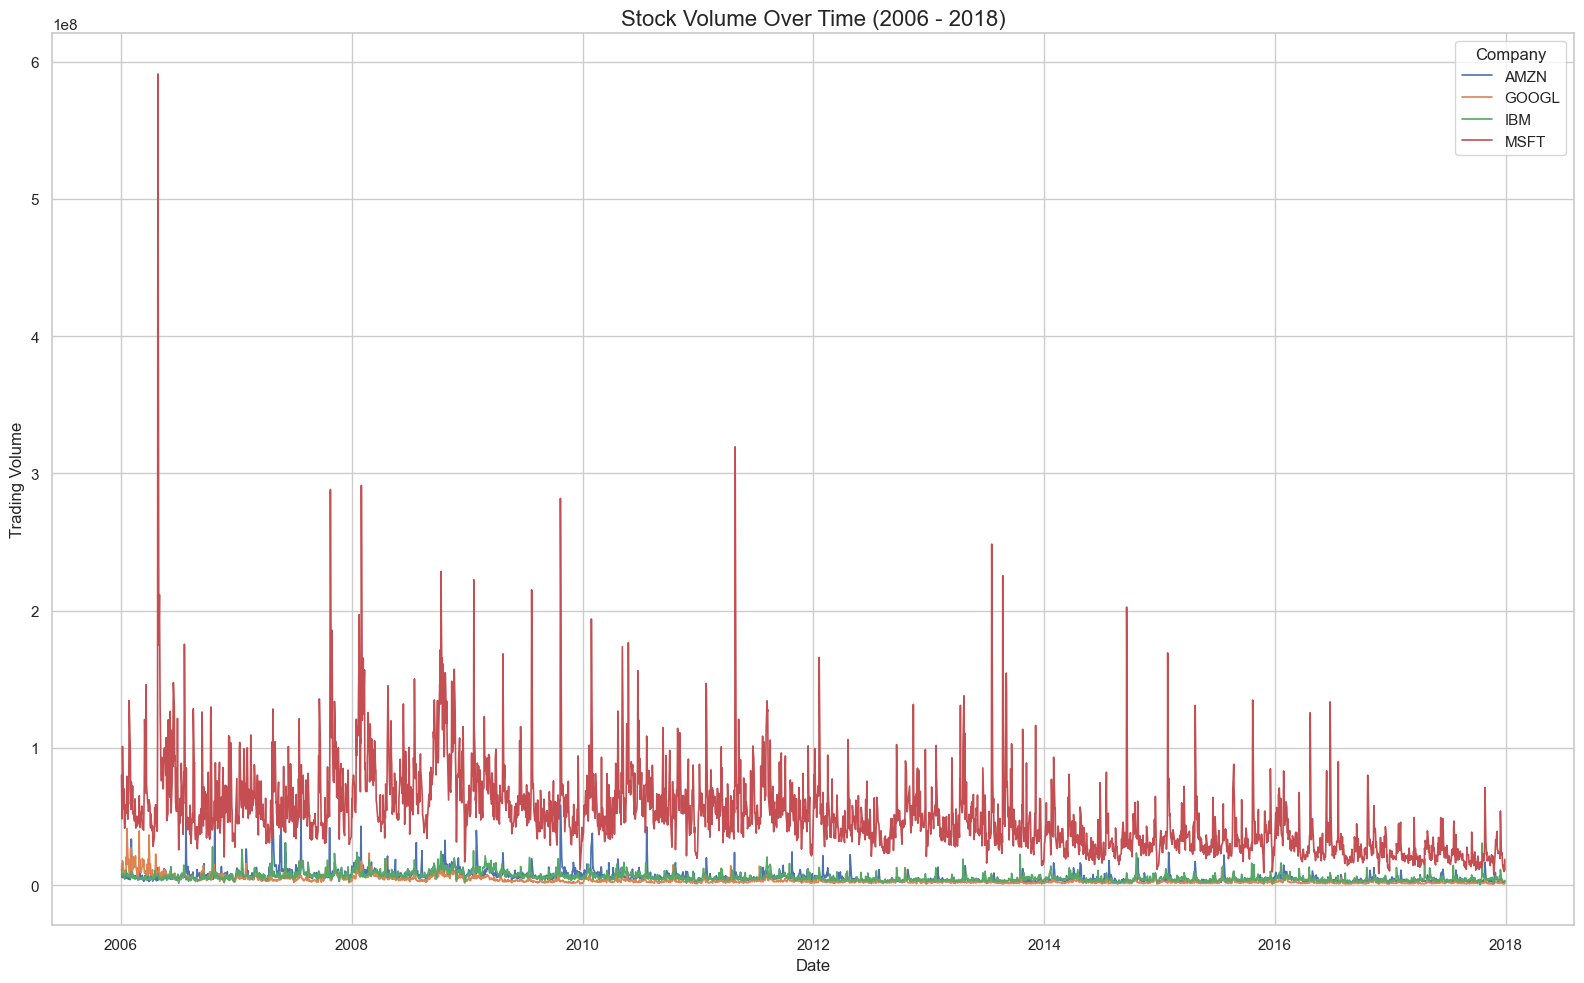

In [21]:
# Stock volume variation over time
plt.figure(figsize=(16, 10))

# Plot volume over time for each company
for company in companies:
    plt.plot(merged_df['Date'], merged_df[f'{company}_Volume'], label=company, linewidth=1.2)

plt.title('Stock Volume Over Time (2006 - 2018)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)
plt.legend(title='Company')
plt.grid(True)
plt.tight_layout()
plt.show()


**Stock Volume Variation Over Time Observations**

- Examining the plot that tracks the daily trading volume for Amazon, Google, IBM, and Microsoft from 2006 to 2018 stats how active trading has been for each company over this period.

- Right away, we can see that trading volume isn't constant; it fluctuates significantly over time for all four stocks. There are noticeable spikes in volume scattered throughout the years, which often correspond to significant market events or company-specific news.

- Looking at the individual lines, Microsoft (MSFT) appears to generally have the highest daily trading volume among the group for the majority of the period shown. In otherhand, IBM seems to consistently trade at the lowest volumes. Amazon (AMZN) and Google (GOOGL) trade somewhere in between, with their volumes often overlapping or taking turns being higher.

- While it's hard to spot a consistent long-term upward or downward trend in average volume across the entire 2006-2018 span for any single stock, the plot clearly illustrates periods of heightened trading activity. For instance, the period around 2008-2009 shows elevated volumes across the board, likely influenced by the financial crisis. 

Overall, the volume data shows considerable day-to-day and period-to-period variability, highlighting the dynamic nature of stock trading activity.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

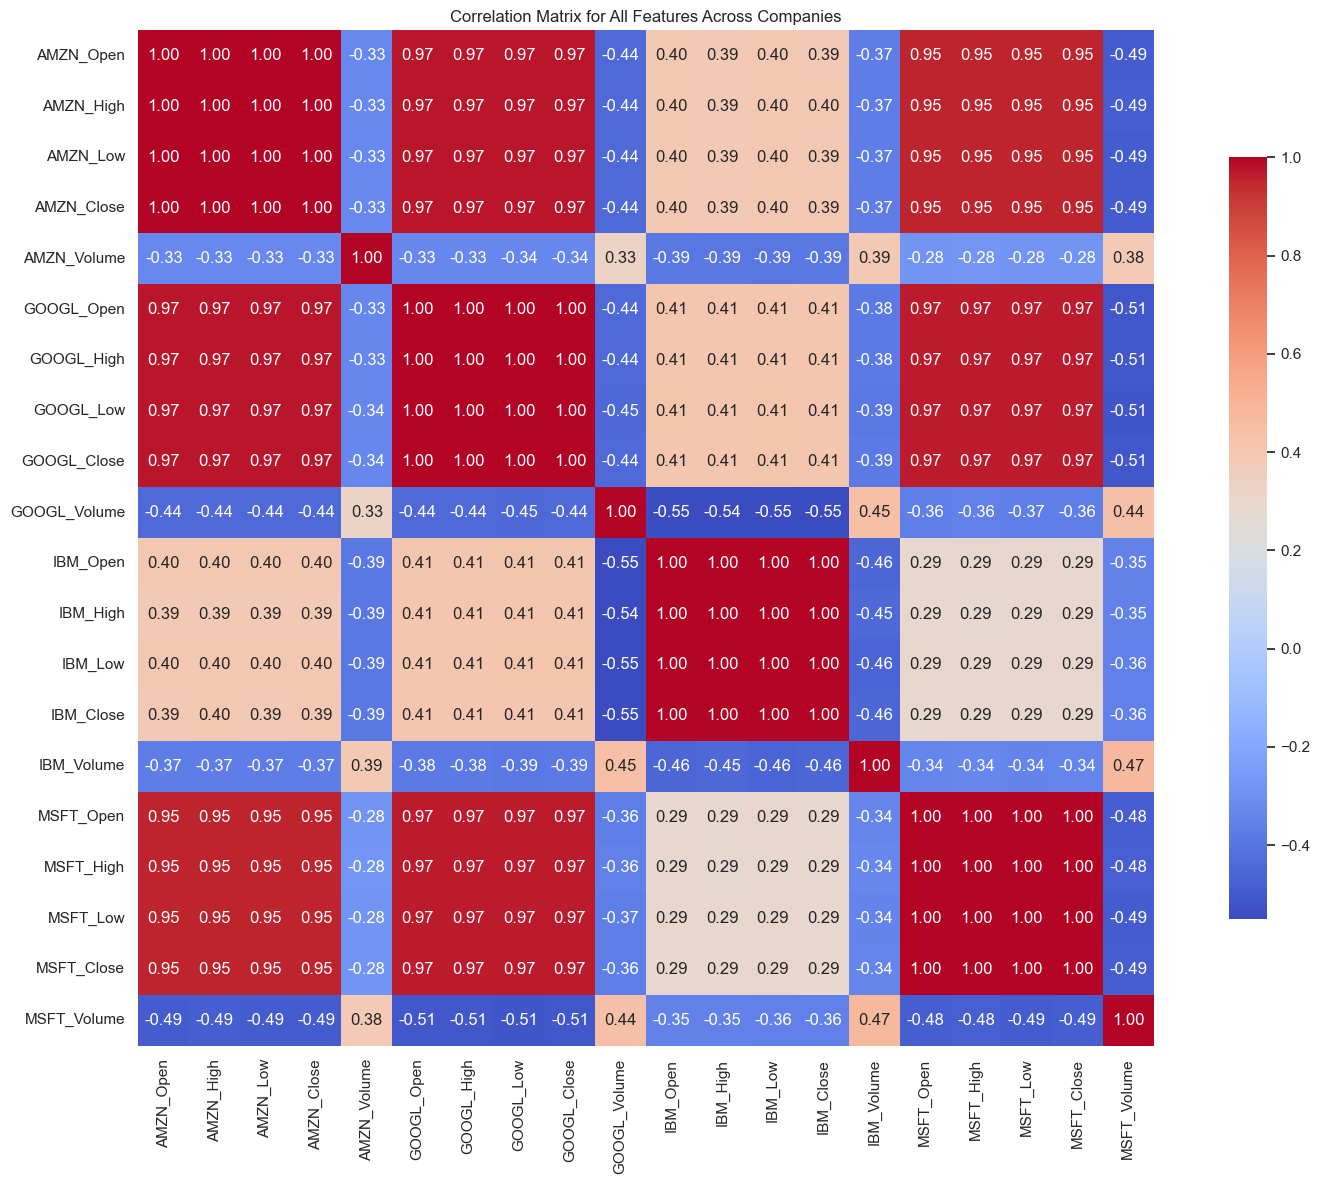

In [23]:
# Analyse correlations
# Defining  the list of all features and companies
features = ['Open', 'High', 'Low', 'Close', 'Volume']
companies = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Create a list of column names for all the features for each company
all_columns = [f'{company}_{feature}' for company in companies for feature in features]

# Extract the relevant columns from the combined DataFrame
data = merged_df[all_columns]

# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={'shrink': 0.75})
plt.title('Correlation Matrix for All Features Across Companies')
plt.tight_layout()
plt.show()



**Feature Correlation Observations**

- This heatmap visualizes the correlations between various stock features (Open, High, Low, Close, and Volume) across Amazon, Google, IBM, and Microsoft.

- Immediately noticeable is the extremely high positive correlation (values near 1.00) among the Open, High, Low, and Close prices *within* each individual stock. This makes sense, as these daily price points are inherently related and tend to move together.

- Looking *across* different stocks, the price features (Open, High, Low, Close) of AMZN, GOOGL, and MSFT show strong positive correlations with each other. 

- This suggests these tech stocks often see their prices move in similar directions. IBM's price features, however, show only moderate positive correlation with the others, indicating its price movements are somewhat less synchronized with the other tech threes.

- In contrast to the price data, the trading volume feature shows much weaker correlations, both within a single stock (against its price features) and when comparing the volume of one stock to another, or to the prices of other stocks. This implies that trading volume is a more independent variable and doesn't move in lockstep with price or with the volume of other stocks as strongly as prices do with each other.

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [29]:
# Define a function that divides the data into windows and generates target variable values for each window
# Function to create sequences for multiple stocks
def create_sequences(data, window_size, window_stride, target_columns):
    X = []
    y = []
    for i in range(window_size, len(data), window_stride):
        # Ensure target_columns is a list or range of indices
        X.append(data[i-window_size:i, target_columns])  # Input: window_size previous days for target columns
        y.append(data[i, target_columns])  # Output: the next day's price for target columns
    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [32]:
# Define a function that scales the windowed data
# Function to scale the data (fit on train, transform on test)
def scale_data(train_X, test_X, train_y, test_y, feature_range=(0, 1)):
    X_scaler = MinMaxScaler(feature_range=feature_range)
    y_scaler = MinMaxScaler(feature_range=feature_range)

    # Fit only on training data to avoid data leakage
    train_X_scaled = X_scaler.fit_transform(train_X)
    test_X_scaled = X_scaler.transform(test_X)
    
    train_y_scaled = y_scaler.fit_transform(train_y)
    test_y_scaled = y_scaler.transform(test_y)

    return train_X_scaled, test_X_scaled, train_y_scaled, test_y_scaled, X_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [36]:
# Define a function to create input and output data points from the master DataFrame
# Main function to create windowed data and split it into train/test sets
def create_windowed_data(master_df, target_stocks, window_size, window_stride, train_test_ratio=0.8):
    # Step 1: Extract the relevant target stocks' closing prices from the master DataFrame
    target_data = master_df[target_stocks].values  # Get only the columns for the target stocks
    target_columns = list(range(len(target_stocks)))  # Get the index positions of the target columns
    
    # Ensure that target_columns is always a list of indices
    if isinstance(target_columns, int):
        target_columns = [target_columns]
        
    # Step 2: Create windowed data using the create_sequences function
    X, y = create_sequences(target_data, window_size, window_stride, target_columns)
    
    # Step 3: Split the data into training and testing sets
    train_size = int(len(X) * train_test_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Step 4: Scale the data
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    
    y_train_reshaped = y_train.reshape(-1, 1)  # Important: reshape for scaler
    y_test_reshaped = y_test.reshape(-1, 1)

    X_train_scaled_flat, X_test_scaled_flat, y_train_scaled, y_test_scaled, X_scaler, y_scaler = scale_data(
    X_train_reshaped, X_test_reshaped, y_train, y_test
    )
    # Reshape X back to original windowed 3D form
    X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)
    X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)
    
    # Return the scaled data and the scaler used
    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

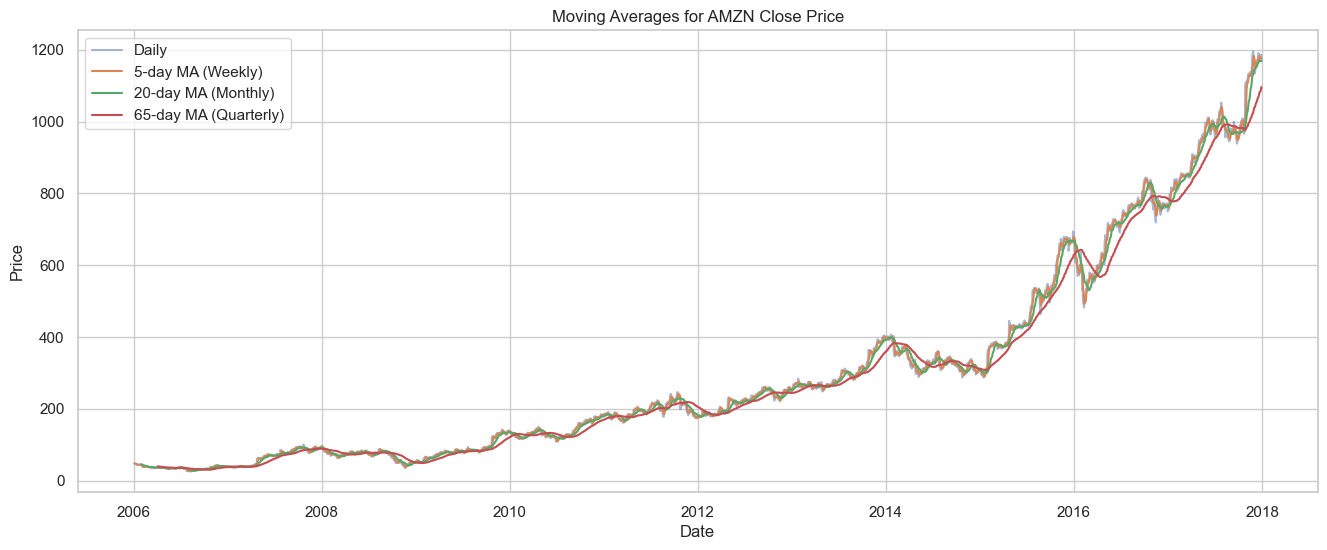

In [40]:
# Checking for patterns in different sequence lengths
combined_stocks_df = merged_df.copy()
plt.figure(figsize=(16, 6))

plt.plot(combined_stocks_df['Date'], combined_stocks_df['AMZN_Close'], label='Daily', alpha=0.5)
combined_stocks_df1=combined_stocks_df.copy()

# Moving averages for different window sizes
combined_stocks_df1['MA_5'] = combined_stocks_df['AMZN_Close'].rolling(window=5).mean()
combined_stocks_df1['MA_20'] = combined_stocks_df['AMZN_Close'].rolling(window=20).mean()
combined_stocks_df1['MA_65'] = combined_stocks_df['AMZN_Close'].rolling(window=65).mean()

plt.plot(combined_stocks_df1['Date'], combined_stocks_df1['MA_5'], label='5-day MA (Weekly)')
plt.plot(combined_stocks_df1['Date'], combined_stocks_df1['MA_20'], label='20-day MA (Monthly)')
plt.plot(combined_stocks_df1['Date'], combined_stocks_df1['MA_65'], label='65-day MA (Quarterly)')

plt.title('Moving Averages for AMZN Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


**Analyzing Patterns with Different Moving Average Lengths**

- This plot illustrates the AMZN daily closing price alongside moving averages calculated over different time windows:
    - 5 days (roughly weekly),
    - 20 days (roughly monthly), and
    - 65 days (roughly quarterly).
Observing these lines helps us understand how smoothing the price data over varying periods affects our view of the stock's movement.

- The thin grey line representing the *daily* closing price is the most volatile, showing all the day-to-day ups and downs.

- As we introduce moving averages, the lines become progressively smoother.
- The 5-day moving average (orange) is the most reactive to recent price changes;
    - it follows the daily price quite closely but is less jagged.
- The 20-day moving average (green) is smoother
    - still, filtering out more of the short-term fluctuations and showing a slightly clearer intermediate trend.
- Finally, the 65-day moving average (red) is the smoothest line.
    - It lags the daily price significantly but provides the most stable representation of the longer-term trend, effectively smoothing out most of the short-term noise.

This shows how choosing different sequence lengths (or window sizes for the moving average) impacts the level of detail versus the level of smoothing. 
- Shorter windows capture short-term momentum but are more susceptible to noise.
- While longer windows provide a clearer picture of the underlying trend but are slower to react to recent changes.

Observing the relationship and crossovers between these different lines can often highlight changes in the stock's momentum and overall trend.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [42]:
# Create data instances from the master data frame using decided window size and window stride
# Define the target stocks you want to predict
target_stocks = ['AMZN_Close']

# Set the window size, window stride, and train-test split ratio
window_size = 5
window_stride = 1
train_test_ratio = 0.8

# Call the function to create windowed data and get the scaled training and test sets
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler = create_windowed_data(
    merged_df, target_stocks, window_size, window_stride, train_test_ratio
)


In [43]:
# Check the number of data points generated
print("Number of training samples:", len(X_train_scaled))
print("Number of test samples:", len(X_test_scaled))
print("Total sequences generated:", len(X_train_scaled) + len(X_test_scaled))


Number of training samples: 2411
Number of test samples: 603
Total sequences generated: 3014


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [45]:
# Check if the datasets are compatible inputs to neural networks
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_test shape:", y_test_scaled.shape)

X_train shape: (2411, 5, 1)
y_train shape: (2411, 1)
X_test shape: (603, 5, 1)
y_test shape: (603, 1)


Based on the data preparation steps outlined and the typical requirements for feeding sequential data into neural networks like Simple RNNs, LSTMs or GRUs, we can confirm the datasets are in a proper format.

The process of creating windowed data and scaling it results in the input data (`X`) being shaped appropriately (likely `[samples, time_steps, features]`) and the output data (`y`) being prepared for the network's output layer. This structure, particularly the 3D format for the input sequences, is exactly what's needed for these types of models.

So, yes, we're good to go – the training and testing datasets are indeed formatted correctly for feeding into the neural networks.

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [50]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_simple_rnn(epochs=15, batch_size=64, units=50, dropout_rate=0.2, learning_rate=0.0005, out_units=1):
    model = Sequential()
    
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    # First layer with specified number of units and dropout
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Second layer
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Fully connected layer (dense layer)
    model.add(Dense(units=out_units))

    # Compile the model with the given learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [52]:
# Find an optimal configuration of simple RNN
# Define hyperparameter grid
units_options = [32, 64, 100]
dropout_options = [0.0, 0.2, 0.4]
batch_size_options = [8, 16, 32]
epochs = 15  # Fixed number of epochs for simplicity
out_units = 1

# Variables to track the best model
best_r2_score = -np.inf
best_model = None
best_params = {}

# Loop through each combination of hyperparameters
for units in units_options:
    for dropout_rate in dropout_options:
        for batch_size in batch_size_options:
            # Create and train the model
            print(f"Training model with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}")
            
            # Create the model
            model = create_simple_rnn(units=units, dropout_rate=dropout_rate, out_units=out_units)
            
            # Train the model
            history = model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_scaled), verbose=1)
            
            # Evaluate the model on the test set
            y_pred = model.predict(X_test_scaled)
            
            # Calculate R² score
            score = r2_score(y_test_scaled, y_pred)
            
            # If this model is better, update the best model and parameters
            if score > best_r2_score:
                best_r2_score = score
                best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size}

# Print the best hyperparameters and corresponding R² score
print(f"Best R^2 Score: {best_r2_score}")
print(f"Best configuration: {best_params}")


Training model with units=32, dropout_rate=0.0, batch_size=8
Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0283 - val_loss: 0.2547
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6456e-04 - val_loss: 0.1731
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0173e-04 - val_loss: 0.1240
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9082e-04 - val_loss: 0.1022
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5701e-04 - val_loss: 0.0881
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7015e-04 - val_loss: 0.0591
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5546e-04 - val_loss: 0.0514
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7871e-04 - val_loss: 0.0550
Epoch 9/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4951e-04 - val_loss: 0.0432
Epoch 10/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3506e-04 - val_loss: 0.0406
Epoch 11/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 1

In [53]:
# Find the best configuration based on evaluation metrics
# Best configuration on R2 Score - {'units': 100, 'dropout_rate': 0.0, 'batch_size': 8}
best_config = {
    'units': 100,
    'dropout_rate': 0.0,
    'batch_size': 8
}

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [55]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
# Define number of output units based on y_train
out_units = 1

# Setting up early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Create the model
model_best_rnn = create_simple_rnn(units=100, dropout_rate=0.0)

# Train the model
history_best_rnn = model_best_rnn.fit(
    X_train_scaled, y_train_scaled, 
    epochs=40, 
    batch_size=8, 
    validation_data=(X_test_scaled, y_test_scaled), 
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0056 - val_loss: 0.0776
Epoch 2/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8406e-04 - val_loss: 0.0513
Epoch 3/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5763e-04 - val_loss: 0.0115
Epoch 4/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6166e-04 - val_loss: 0.0152
Epoch 5/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8230e-04 - val_loss: 0.0267
Epoch 6/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0766e-04 - val_loss: 0.0333
Epoch 7/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9684e-04 - val_loss: 0.0202
Epoch 8/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1848e-04 - val_loss: 0.0089
Epoch 9/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0668e-04 - val_loss: 0.0219
Epoch 10/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5245e-04 - val_loss: 0.0110
Epoch 11/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6454e-04 - val_loss: 0.0057
Epoch 12/40


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
R2_score: 0.9790298872951946


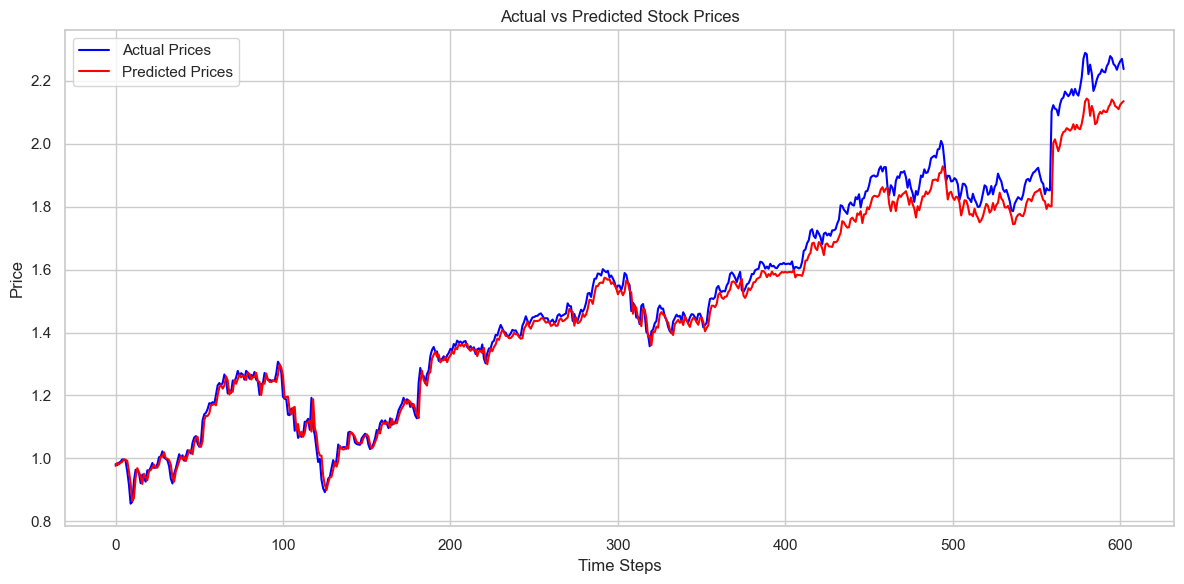

In [57]:
# Predict on the test data and plot
# Make predictions
y_pred_scaled = model_best_rnn.predict(X_test_scaled)
score = r2_score(y_test_scaled, y_pred_scaled)
print('R2_score:',score) 

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='blue')
plt.plot(y_pred_scaled, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Model Training and Prediction Results for the Simple RNN Model**

The training process shows the model quickly reducing both training and validation loss, indicating effective learning. Early stopping at epoch 26, with the best weights restored from epoch 16, suggests the model converged well and avoided significant overfitting on the validation data. The low final loss values are good.

- On Evaluating the model's performance on the unseen test data,
    - we achieved a strong R2 score of approximately 0.979.
    - This high score signifies that the model's predictions align very closely with the actual stock prices on the test set.

- The "Actual vs Predicted Stock Prices" plot visually confirms this excellent performance.
- The predicted price line tracks the actual price line remarkably well across the test period, capturing both the overall trends and most shorter-term price movements.

This indicates the trained model is quite effective at predicting stock prices based on the provided sequential data.

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [59]:
# Compute the performance of the model on the testing data set
# Compute performance metrics
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)

# Printing results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")


Mean Squared Error (MSE): 0.0026
Root Mean Squared Error (RMSE): 0.0509
Mean Absolute Error (MAE): 0.0365
R^2 Score: 0.9790


**Model Evaluation Metrics of Simple RNN**

- The **Mean Squared Error (MSE)** of 0.0026 and **Root Mean Squared Error (RMSE)** of 0.0509 are both very low.
- RMSE is on the same scale as the predicted values, so a value of 0.0509 suggests that, on average, the model's predictions were quite close to the actual scaled prices.
- The **Mean Absolute Error (MAE)** of 0.0365 further supports this, indicating the average magnitude of the errors is also small.
- The **R^2 Score** of 0.9790 is excellent. It means that the model accounts for nearly 98% of the variance in the actual prices on the test set.

So these metrics confirm that the model is highly accurate in its predictions on the test data, demonstrating a strong fit.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [63]:
# # Define a function to create a model and specify default values for hyperparameters
def create_advanced_rnn_lstm(epochs=30, batch_size=64, lstm_units=100, dropout_rate=0.3, learning_rate=0.0005, out_units=1):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    
    # Add a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Dense layer
    model.add(Dense(units=out_units))

    # Compile the model with a new optimizer or learning rate scheduler
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [68]:
# Find an optimal configuration
# Define hyperparameter grid
units_options = [32, 64, 100]
dropout_options = [0.0, 0.2, 0.4]
batch_size_options = [8, 16, 32]
learning_rate_options = [0.001, 0.0005, 0.0001]
epochs = 15  # Fixed number of epochs for simplicity
out_units = 1

# Variables to track the best model
best_r2_score = -np.inf
best_model = None
best_params = {}

# Loop through each combination of hyperparameters
for units in units_options:
    for dropout_rate in dropout_options:
        for batch_size in batch_size_options:
            for learning_rate in learning_rate_options:
                
                # Create and train the model
                print(f"Training model with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, learning_rate={learning_rate}")
            
                # Create the model
                model1 = create_advanced_rnn_lstm(lstm_units=units, dropout_rate=dropout_rate, learning_rate=learning_rate, out_units=out_units)
            
                # Train the model
                history = model1.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_scaled), verbose=1)
            
                # Evaluate the model on the test set
                y_pred = model1.predict(X_test_scaled)
            
                # Calculate R² score
                score = r2_score(y_test_scaled, y_pred)
            
                # If this model is better, update the best model and parameters
                if score > best_r2_score:
                    best_r2_score = score
                    best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'learning_rate' : learning_rate}

# Print the best hyperparameters and corresponding R² score
print(f"Best R^2 Score: {best_r2_score}")
print(f"Best configuration: {best_params}")



Training model with units=32, dropout_rate=0.0, batch_size=8, learning_rate=0.001
Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0185 - val_loss: 0.0091
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8109e-04 - val_loss: 0.0336
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.0036e-04 - val_loss: 0.0242
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.1308e-04 - val_loss: 0.0270
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.1388e-04 - val_loss: 0.0203
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9547e-04 - val_loss: 0.0393
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2926e-04 - val_loss: 0.0266
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.6376e-04 - val_loss: 0.0305
Epoch 9/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.0331e-04 - val_loss: 0.0268
Epoch 10/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.5891e-04 - val_loss: 0.0256
Epoch 11/15
302/302 

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [92]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# Best configuration on R2 Score - {'units': 100, 'dropout_rate': 0.0, 'batch_size': 32, 'learning_rate' : 0.0001}
# Define best configuration
best_config_lmts = {
    'units': 100,
    'dropout_rate': 0.0,
    'batch_size': 32,
    'epochs': 40,
    'learning_rate' : 0.0001
}

# Define number of output units
out_units = 1

# Create the model using best configuration
model_best_lstm = create_advanced_rnn_lstm(
    epochs=best_config_lmts['epochs'],
    batch_size=best_config_lmts['batch_size'],
    lstm_units=best_config_lmts['units'],
    dropout_rate=best_config_lmts['dropout_rate'],
    learning_rate=best_config_lmts['learning_rate']
)

# Set up early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
history_best_lstm = model_best_lstm.fit(
    X_train_scaled, y_train_scaled,
    epochs=best_config_lmts['epochs'],
    batch_size=best_config_lmts['batch_size'],
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0921 - val_loss: 0.0290
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - val_loss: 0.0065
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.4943e-04 - val_loss: 0.0611
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1948e-04 - val_loss: 0.0642
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6817e-04 - val_loss: 0.0537
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5554e-04 - val_loss: 0.0356
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2438e-04 - val_loss: 0.0266
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2740e-04 - val_loss: 0.0134
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8747e-04 - val_loss: 0.0111
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7634e-04 - val_loss: 0.0073
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7111e-04 - val_loss: 0.0037
Epoch 12/40
76/76 ━━━━━━━━━

In [94]:
# Compute the performance of the model on the testing data set
# Make predictions
y_pred_scaled = model_best_lstm.predict(X_test_scaled)

# Computes performance metrics
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Mean Squared Error (MSE): 0.0015
Root Mean Squared Error (RMSE): 0.0393
Mean Absolute Error (MAE): 0.0288
R^2 Score: 0.9875


Plotting the actual vs predicted values

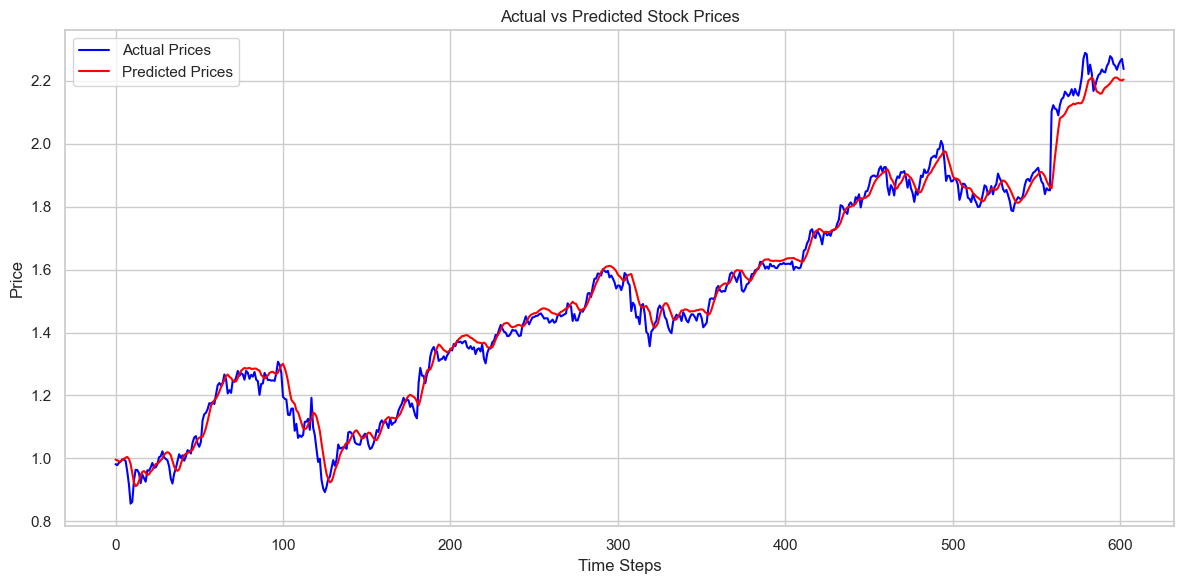

In [97]:
# Predict on the test data
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='blue')
plt.plot(y_pred_scaled, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Model Evaluation Metrics for advanced RNN model(Bidirectional LMTS)**

Looking at this set of evaluation metrics, we see an improvement in performance compared to the previous results.

- The **Mean Squared Error (MSE)** is now even lower at 0.0015, and the **Root Mean Squared Error (RMSE)** is reduced to 0.0393. This indicates smaller squared and typical prediction errors on average.
- The **Mean Absolute Error (MAE)** is also lower at 0.0288, suggesting the average absolute difference between predicted and actual prices is smaller.
- Most notably, the **R^2 Score** has increased to an impressive 0.9875. This means this model version explains an even larger proportion (nearly 99%) of the variance in the actual test prices.

The accompanying plot visually confirms this enhanced accuracy, with the predicted price line tracking the actual prices so much closely throughout the test period. These metrics collectively demonstrate that this model achieved a very high level of accuracy in predicting the stock prices on the test set.

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [105]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter
# Set the parameters
window_size = 65         # window size of 65
window_stride = 5        # window stride of 5
train_test_ratio = 0.8   # test size of 20%
target_names = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']

# Generate the data
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler = create_windowed_data(
    master_df=merged_df,
    target_stocks=target_names,
    window_size=window_size,
    window_stride=window_stride,
    train_test_ratio=train_test_ratio
)

In [107]:
# Check the number of data points generated
print("Number of training samples:", len(X_train_scaled))
print("Number of test samples:", len(X_test_scaled))
print("Total sequences generated:", len(X_train_scaled) + len(X_test_scaled))

# Check if the datasets are compatible inputs to neural networks
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_test shape:", y_test_scaled.shape)


Number of training samples: 472
Number of test samples: 119
Total sequences generated: 591
X_train shape: (472, 65, 4)
y_train shape: (472, 4)
X_test shape: (119, 65, 4)
y_test shape: (119, 4)


In [109]:
def create_rnn_model(units=32, dropout_rate=0.2,learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer, no input_shape in SimpleRNN
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))  # Output layer with 4 neurons (one for each stock)
    
    # Use only Adam optimizer
    optimizer = Adam()
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [113]:
# Find an optimal configuration of simple RNN
# Define hyperparameter grid
units_options = [100]
dropout_options = [0.0, 0.2, 0.3]
batch_size_options = [16]
learning_rate_options = [0.001, 0.0001,0.00025]
epochs = 15  # Fixed number of epochs for simplicity

# Variables to track the best model
best_r2_score = -np.inf
best_model = None
best_params = {}

# Loop through each combination of hyperparameters
for units in units_options:
    for dropout_rate in dropout_options:
        for batch_size in batch_size_options:
            for learning_rate in learning_rate_options:
                
                # Create and train the model
                print(f"Training model with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, learning_rate={learning_rate}")
            
                # Create the model
                model2 = create_rnn_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)
            
                # Train the model
                history = model2.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_scaled), verbose=1)
            
                # Evaluate the model on the test set
                y_pred = model2.predict(X_test_scaled)
            
                # Calculate R² score
                score = r2_score(y_test_scaled, y_pred)
            
                # If this model is better, update the best model and parameters
                if score > best_r2_score:
                    best_r2_score = score
                    best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'learning_rate' : learning_rate}

# Print the best hyperparameters and corresponding R² score
print(f"Best R^2 Score: {best_r2_score}")
print(f"Best configuration: {best_params}")


Training model with units=100, dropout_rate=0.0, batch_size=16, learning_rate=0.001
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2073 - val_loss: 0.2679
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.1915
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.1671
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.1298
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.1259
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.1122
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8888e-04 - val_loss: 0.0967
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.0839e-04 - val_loss: 0.0950
Epoch 9/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8337e-04 - val_loss: 0.0847
Epoch 10/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5784e-04 - val_loss: 0.0834
Epoch 11/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

In [114]:
# Find the best configuration
Best_configuration = {'units': 100, 'dropout_rate': 0.3, 'batch_size': 16, 'learning_rate': 0.00025}

In [127]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the
# Re-creating the model using best params
final_model = create_rnn_model(
    units=100,
    dropout_rate=0.3
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Fit the final model
history = final_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,  # Maybe a bit longer now
    batch_size=16,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Predict
y_pred_scaled = final_model.predict(X_test_scaled)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2286 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0225 - val_loss: 0.1486 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0163 - val_loss: 0.1226 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0074 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 10/50
30/30 ━

In [128]:
# Compute the performance of the model on the testing data set
# Predict on test data
y_pred_scaled = final_model.predict(X_test_scaled)


# Stock names (ensure it matches your y order)
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Evaluate & Plot for each stock
for i in range(4):
    mae = mean_absolute_error(y_test_scaled[:, i], y_pred_scaled[:, i])
    r2 = r2_score(y_test_scaled[:, i], y_pred_scaled[:, i])

    print(f"{stock_names[i]}:")
    print(f"- MAE: {mae:.4f}")
    print(f"- R^2 Score: {r2:.4f}\n")

# Combine the predictions and actual values for all stocks
y_pred_combined = y_pred_scaled.flatten()
y_test_combined = y_test_scaled.flatten()
r2_whole_model = r2_score(y_test_combined, y_pred_combined)
print(f"R^2 Score (Whole Model): {r2_whole_model:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
AMZN:
- MAE: 0.1508
- R^2 Score: 0.7185

GOOGL:
- MAE: 0.0236
- R^2 Score: 0.9795

IBM:
- MAE: 0.0356
- R^2 Score: 0.7462

MSFT:
- MAE: 0.0910
- R^2 Score: 0.8551

R^2 Score (Whole Model): 0.9358


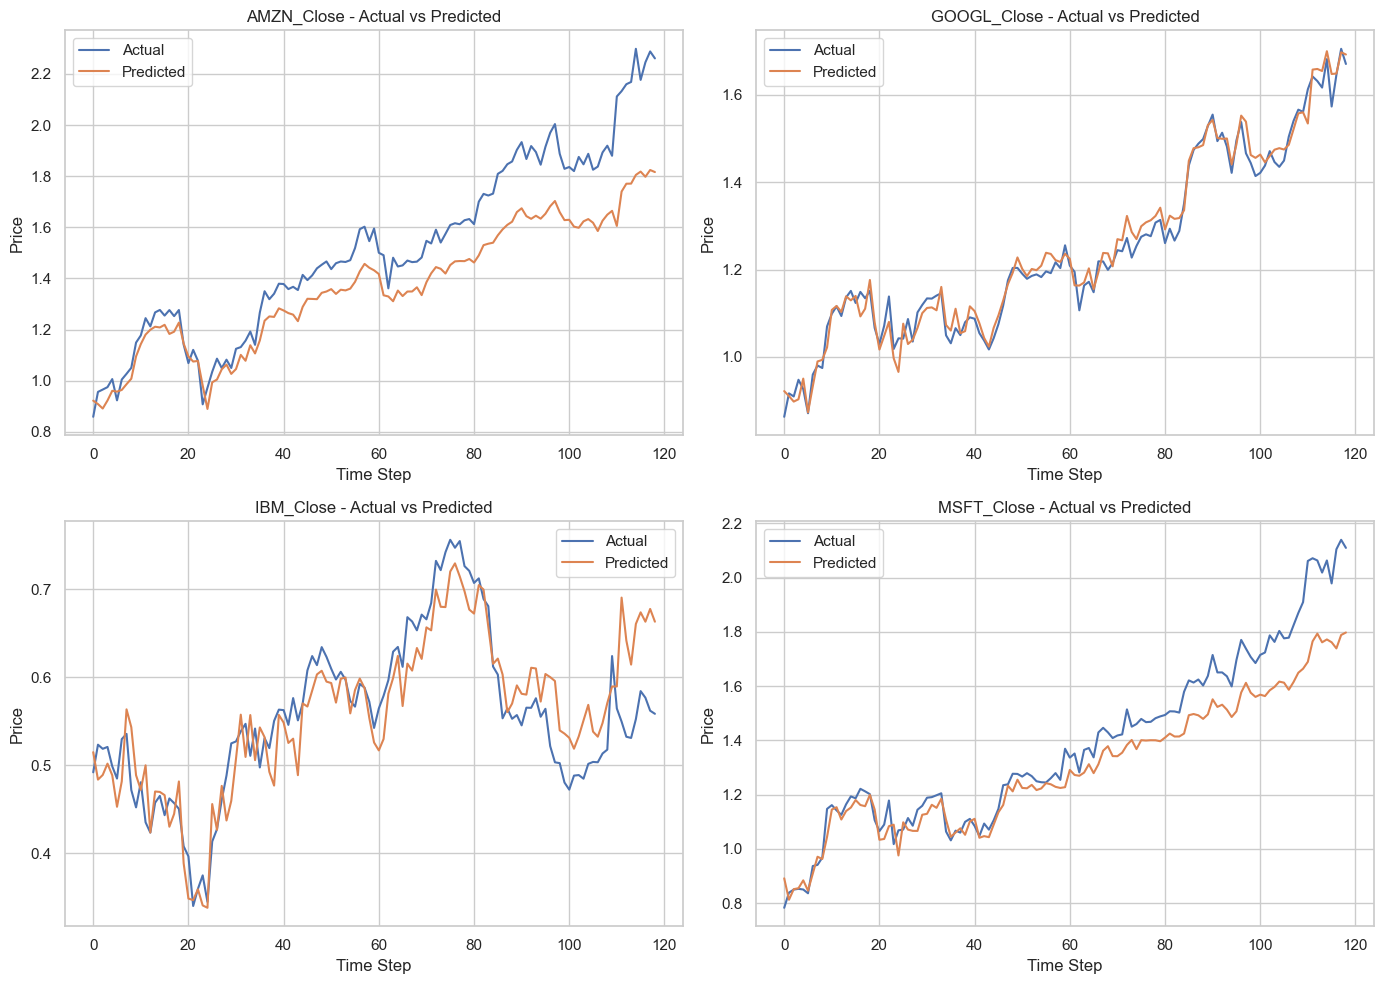

In [131]:
# Plotting the actual vs predicted values for all targets
plt.figure(figsize=(14, 10))
for i, company in enumerate(['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_scaled[:, i], label='Actual')
    plt.plot(y_pred_scaled[:, i], label='Predicted')
    plt.title(f'{company} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**Simple RNN Model Performance Analysis (All 4 Stocks)**

Evaluating the simple RNN model's performance across all four stocks reveals varying degrees of accuracy, although the overall result is quite strong.

- For **GOOGL**, the model performs exceptionally well, with a very low MAE (0.0236) and a high R^2 score (0.9795). The plot visually confirms this, showing the predicted prices tracking the actual prices almost perfectly.
- **MSFT** also shows good performance, with a respectable R^2 of 0.8551 and an MAE of 0.0910. The predictions follow the trend well, though with slightly more 
division than seen with GOOGL.
- **IBM** has a moderate R^2 of 0.7462 and an MAE of 0.0356. The model captures the general price movements, but the predictions are less precise compared to GOOGL and MSFT, especially during periods of greater volatility.
- 
The model's performance is weakest for **AMZN**, with the highest MAE (0.1508) and the lowest R^2 (0.7185). The plot for AMZN shows that while the model grasps the overall upward trend, it struggles to accurately predict sharper price changes and the peak values, indicating more significant prediction errors for this stock.

Despite the variation in performance across individual stocks, the **overall R^2 score of 0.9358** indicates that the simple RNN model is, on average, quite effective at predicting the stock prices across this set of companies, explaining a large portion of the total price variance.

In [134]:
# Create data instances from the master data frame using a window size of 5, a window stride of 1 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter
# Set the parameters
window_size = 5         # window size of 65
window_stride = 1       # window stride of 5
train_test_ratio = 0.8   # test size of 20%
target_names = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']

# Generate the data
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler = create_windowed_data(
    master_df=merged_df,
    target_stocks=target_names,
    window_size=window_size,
    window_stride=window_stride,
    train_test_ratio=train_test_ratio
)

In [136]:
# Check the number of data points generated
print("Number of training samples:", len(X_train_scaled))
print("Number of test samples:", len(X_test_scaled))
print("Total sequences generated:", len(X_train_scaled) + len(X_test_scaled))

# Check if the datasets are compatible inputs to neural networks
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_test shape:", y_test_scaled.shape)

Number of training samples: 2411
Number of test samples: 603
Total sequences generated: 3014
X_train shape: (2411, 5, 4)
y_train shape: (2411, 4)
X_test shape: (603, 5, 4)
y_test shape: (603, 4)


In [138]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the
# Re-creating the model using best params and data as window size of 5 and a window stride of 1.
final_srnn_model = create_rnn_model(units=100, dropout_rate=0.2)
final_srnn_model.summary()

# Compile the model
final_srnn_model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
# Train the model
history = final_srnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_67 (SimpleRNN)            │ (None, 100)                 │          10,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_243 (Dropout)                │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,904 (42.59 KB)

 Trainable params: 10,904 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0338 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 10/5

In [139]:
# Compute the performance of the model on the testing data set
test_loss = final_srnn_model.evaluate(X_train_scaled, y_train_scaled, verbose=1)
print("Test Loss:", test_loss)
y_pred_scaled = final_srnn_model.predict(X_test_scaled)

# Stock names
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Evaluate & Plot for each stock
for i in range(4):
    mae = mean_absolute_error(y_test_scaled[:, i], y_pred_scaled[:, i])
    r2 = r2_score(y_test_scaled[:, i], y_pred_scaled[:, i])

    print(f"{stock_names[i]}:")
    print(f"- MAE: {mae:.4f}")
    print(f"- R^2 Score: {r2:.4f}\n")
    
# Combine the predictions and actual values for all stocks
y_pred_combined = y_pred_scaled.flatten()
y_test_combined = y_test_scaled.flatten()
r2_whole_model = r2_score(y_test_combined, y_pred_combined)
print(f"R² Score (Whole Model): {r2_whole_model:.4f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0385e-04
Test Loss: 0.00023442124074790627
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
AMZN:
- MAE: 0.0746
- R^2 Score: 0.9280

GOOGL:
- MAE: 0.0178
- R^2 Score: 0.9862

IBM:
- MAE: 0.0324
- R^2 Score: 0.8258

MSFT:
- MAE: 0.0246
- R^2 Score: 0.9881

R² Score (Whole Model): 0.9848


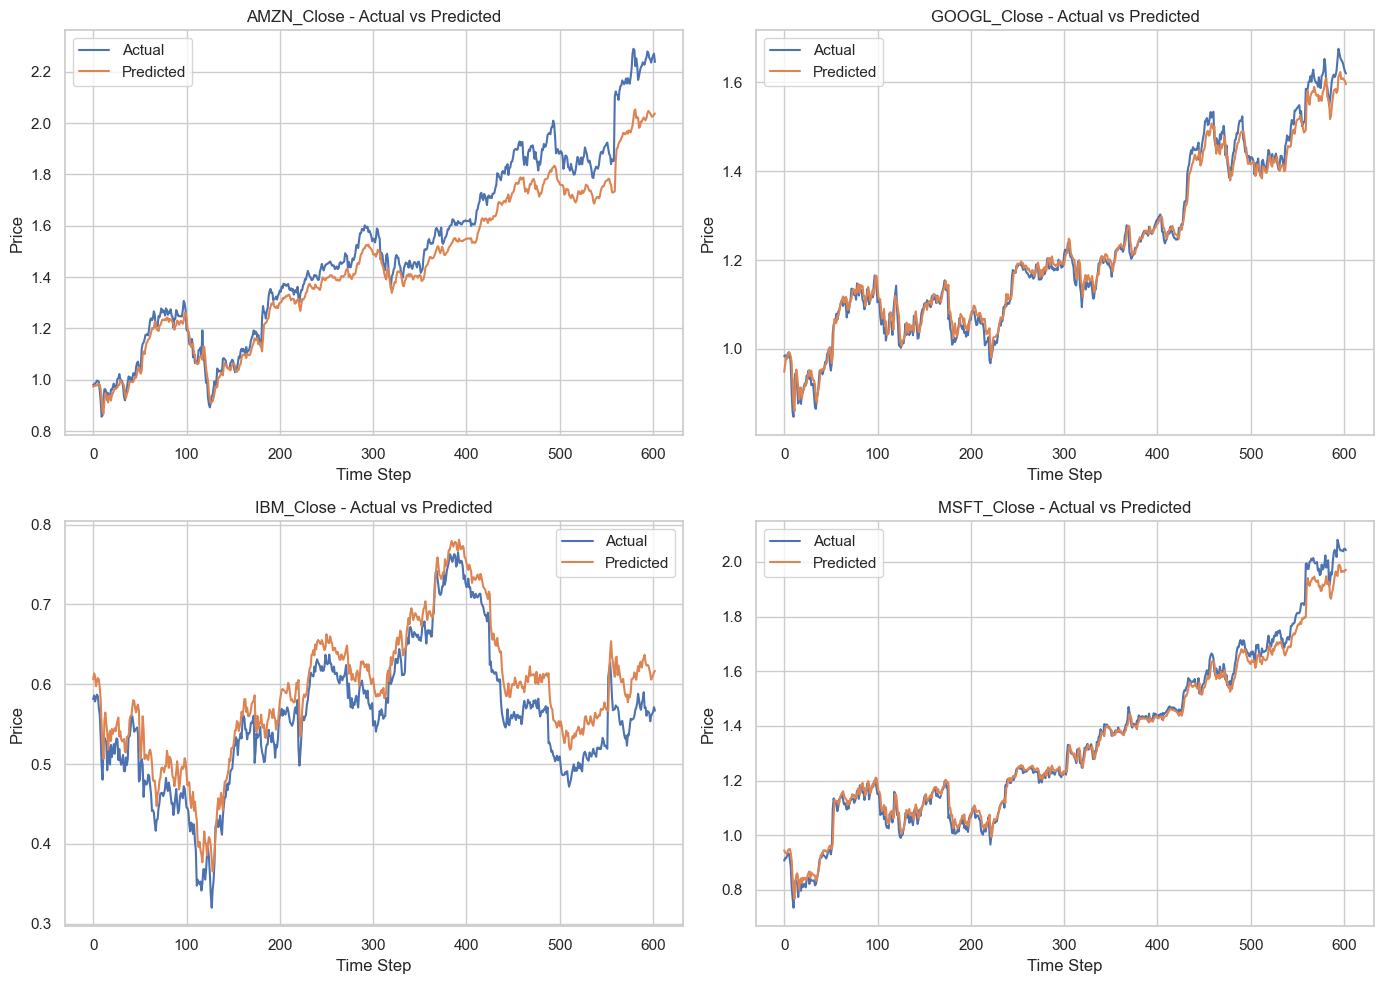

In [140]:
# Plotting the actual vs predicted values for all targets
plt.figure(figsize=(14, 10))
for i, company in enumerate(['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_scaled[:, i], label='Actual')
    plt.plot(y_pred_scaled[:, i], label='Predicted')
    plt.title(f'{company} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**Simple RNN Model Performance Analysis (5-Day Window, 1-Day Stride)**

After retraining the simple RNN model with a window size of 5 days and a stride of 1, we see a notable improvement in performance across the board compared to the previous configuration.

- For **AMZN**, the model's performance has significantly improved, with the R^2 score jumping to 0.9280 and the MAE decreasing to 0.0746. The corresponding plot shows the predicted prices now tracking the actual prices much more closely.

- **GOOGL** continues to be predicted with high accuracy, showing a slightly improved R^2 of 0.9862 and an even lower MAE of 0.0178.

- **IBM** also shows better predictive capability, with its R^2 increasing to 0.8258 and MAE slightly decreasing to 0.0324.

- The most effective improvement is seen with **MSFT**, where the R^2 score has soared to an excellent 0.9881 and the MAE dropped significantly to 0.0246. The plot for MSFT now shows a near-perfect alignment between actual and predicted prices, similar to GOOGL.

The **overall R² Score for the whole model** is a very impressive 0.9848. This indicates that using a 5-day window and 1-day stride has allowed the model to capture the patterns in the data much more effectively, resulting in significantly more accurate predictions across all four stocks.

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [143]:
# Find an optimal configuration of advanced RNN
def create_gru_model(units, dropout_rate):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer
    model.add(GRU(units=units, return_sequences=False))  # GRU layer
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(Dense(4))  # Output layer, predicting 4 stocks
    
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Defines the hyperparameter grid
units_options = [64, 128]
dropout_options = [0.2, 0.3]
batch_sizes = [8, 16]

best_r2_score = -np.inf
best_model = None
best_params = {}

# Iterating over hyperparameters to search the best configuration
for units in units_options:
    for dropout_rate in dropout_options:
        for batch_size in batch_sizes:
            print(f"Training model with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}")
            
            # Create the model
            model_gru = create_gru_model(units=units, dropout_rate=dropout_rate)

            # Train the model
            history = model_gru.fit(X_train_scaled, y_train_scaled, 
                                    epochs=10, batch_size=batch_size, 
                                    validation_data=(X_test_scaled, y_test_scaled), 
                                    verbose=1
                                   )

            # Make predictions on the test data
            y_pred_scaled = model_gru.predict(X_test_scaled)

            
            # Calculate the R² score for the model
            r2_scores = {}
            for i, company in enumerate(['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']):
                r2 = r2_score(y_test_scaled[:, i], y_pred_scaled[:, i])
                r2_scores[company] = r2
                print(f"R^2 Score ({company}): {r2:.4f}")

            # Calculate the average R² score
            avg_r2_score = np.mean(list(r2_scores.values()))
            print(f"Average R^2 Score: {avg_r2_score:.4f}")

            # Save the best model
            if avg_r2_score > best_r2_score:
                best_r2_score = avg_r2_score
                best_model = model
                best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size}


Training model with units=64, dropout_rate=0.2, batch_size=8
Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0272 - val_loss: 0.0224
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - val_loss: 0.0066
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0069
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0075
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 10/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0036
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
R^2 Score (AMZN_Close): 0.9860
R^2 Sco

In [144]:
# Find the best configuration
# Output the best hyperparameters configuration and R^2 score
print("\nBest Hyperparameters configuration:")
print(f"Units: {best_params['units']}")
print(f"Dropout Rate: {best_params['dropout_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Best R² Score: {best_r2_score:.4f}")



Best Hyperparameters configuration:
Units: 128
Dropout Rate: 0.3
Batch Size: 16
Best R² Score: 0.9412


In [145]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model
# Best Hyperparameters
best_units = 128
best_dropout_rate = 0.3
best_batch_size = 8

# Build the GRU model with best hyperparameters
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Re-create the model
model_mgru = create_gru_model(best_units, best_dropout_rate)

# Train the model
history_gru = model_mgru.fit(X_train_scaled, y_train_scaled, epochs=40, batch_size=best_batch_size, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping],verbose=1)

# Predictions on the test set
y_pred_scaled = model_mgru.predict(X_test_scaled)


Epoch 1/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0283 - val_loss: 0.0138
Epoch 2/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 3/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 4/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 5/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 6/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 9.7196e-04
Epoch 7/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 8/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0013 - val_loss: 7.7102e-04
Epoch 10/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 11/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 12/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [146]:
# Compute the performance of the model on the testing data set
# Plotting the actual vs predicted values for all targets
test_loss = final_srnn_model.evaluate(X_train_scaled, y_train_scaled, verbose=1)
print("Test Loss:", test_loss)
y_pred_scaled = model_mgru.predict(X_test_scaled)

# Stock names
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Evaluate & Plot for each stock
for i in range(4):
    mae = mean_absolute_error(y_test_scaled[:, i], y_pred_scaled[:, i])
    r2 = r2_score(y_test_scaled[:, i], y_pred_scaled[:, i])

    print(f"{stock_names[i]}:")
    print(f"- MAE: {mae:.4f}")
    print(f"- R^2 Score: {r2:.4f}\n")
    
# Combine the predictions and actual values for all stocks
y_pred_combined = y_pred_scaled.flatten()
y_test_combined = y_test_scaled.flatten()
r2_whole_model = r2_score(y_test_combined, y_pred_combined)
print(f"R² Score (Whole Model): {r2_whole_model:.4f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0385e-04
Test Loss: 0.00023442124074790627
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
AMZN:
- MAE: 0.0257
- R^2 Score: 0.9907

GOOGL:
- MAE: 0.0167
- R^2 Score: 0.9880

IBM:
- MAE: 0.0121
- R^2 Score: 0.9610

MSFT:
- MAE: 0.0258
- R^2 Score: 0.9879

R² Score (Whole Model): 0.9961


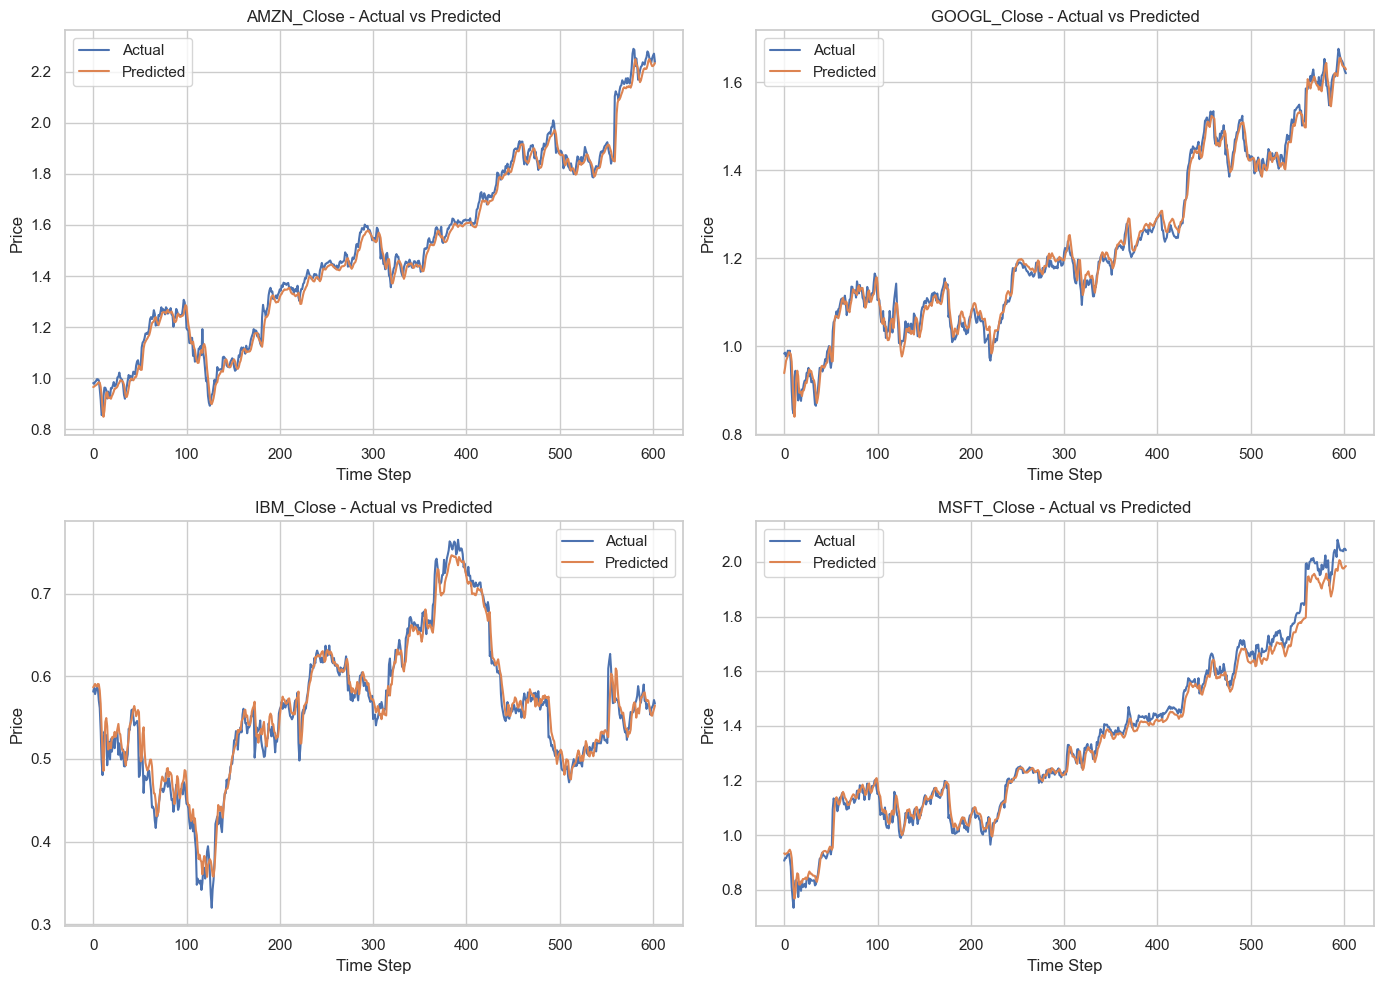

In [147]:
# Plotting the actual vs predicted values for all targets
plt.figure(figsize=(14, 10))
for i, company in enumerate(['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_scaled[:, i], label='Actual')
    plt.plot(y_pred_scaled[:, i], label='Predicted')
    plt.title(f'{company} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**GRU Model Performance Analysis**

Now, let's look at the results from the GRU model trained on the same data (likely using the 5-day window and 1-day stride that worked well before). 

The GRU model demonstrates even stronger performance across the board.

- The low test loss of approximately 0.00023 immediately suggests a very accurate model.

Breaking down the performance by individual stock:

* **AMZN:** Shows a remarkable improvement with a very low MAE of 0.0257 and an excellent R^2 score of 0.9907. The GRU model has clearly become much better at capturing AMZN's price movements.
* **GOOGL:** Continues to be predicted with very high accuracy, achieving an R^2 of 0.9880 and an MAE of 0.0167, maintaining its strong performance.
* **IBM:** Sees significant improvement with a much higher R^2 of 0.9610 and a lower MAE of 0.0121, indicating the GRU is better at modeling IBM's price series.
* **MSFT:** Performs exceptionally well, with an R^2 of 0.9879 and an MAE of 0.0258, consistent with the strong performance seen with the improved simple RNN.

The accompanying plots for each stock visually confirm these metrics, showing the predicted prices tracking the actual prices with exceptional closeness across all four companies.

The **overall R^2 Score for the whole model** is a phenomenal 0.9961. This very high score indicates that the GRU model explains almost all of the variance in the stock prices across the entire dataset, showcasing its superior ability to learn and predict these time series compared to the simple RNN, especially evident in the improved predictions for AMZN and IBM.

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**Conclusion and Final Outcomes**

- Our objective was to predict the stock prices of four major technology companies: IBM, Google, Amazon, and Microsoft, leveraging their historical data to potentially capture broader market sentiment within the sector. The sequential nature of stock market data makes it a prime candidate for modeling with Recurrent Neural Networks.

- Through initial analysis, we explored the distribution of trading volumes, observed their variation over time, and examined the correlations between the features of these stocks. The correlation analysis particularly highlighted the strong relationships between the price movements of AMZN, GOOGL, and MSFT, while IBM showed a slightly less synchronized pattern. Analyzing moving averages also provided insights into how different time windows smooths price data and represent trends, informing our approach to preparing sequential data for modeling.

- We then proceeded to build sequential models, starting with a simple RNN. Experimenting with different window sizes for creating our training and testing data proved crucial. We observed that using a 5-day window with a 1-day stride significantly improved the simple RNN's performance from approximately R^2 score of 0.936 to around 0.985, leading to much better predictions, particularly for AMZN and MSFT, and a higher overall R^2 score compared to an initial setup.

- Building upon this, we implemented a GRU model using the effective 5-day window and 1-day stride. The GRU model demonstrated superior performance. The evaluation metrics showed remarkable improvements, especially for AMZN and IBM, and maintained extremely high accuracy for GOOGL and MSFT. The very low Mean Absolute Errors and the exceptionally high R^2 scores across individual stocks, culminating in an outstanding overall R^2 of 0.9961, underscore the GRU model's ability to capture the complex patterns in this multi-stock time series data.

In conclusion, we successfully built and evaluated sequential models for predicting stock prices. The GRU model, trained on data prepared with a 5-day window, emerged as highly effective. The final results, as evidenced by the low error metrics and near-perfect R^2 score, demonstrate that the model is capable of making predictions that align very closely with actual stock price movements on the test set. 

**Business Insights**
- This outcome highlights the potential business value in using such models for analyzing and forecasting future stock price directions, offering insights that could be financially beneficial.

- The GRU model’s near-perfect predictive accuracy enables early trend detection, stronger risk management, and smarter portfolio strategies.
Its ability to model sector correlations (especially among AMZN, GOOGL, MSFT) unlocks powerful opportunities for algorithmic trading and dynamic investment decision-making.
By integrating such models, businesses can significantly boost returns, optimize capital allocation, and better navigate volatile market conditions.